# Modelo

##### Product Development
##### Gustavo Alvarado
##### Carnet # 20063401 


In [1]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 16.9 MB/s 
     |████████████████████████████████| 140 kB 49.8 MB/s 
     |████████████████████████████████| 62 kB 928 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

import seaborn as sn
from sklearn.metrics import confusion_matrix

## Obteniendo características

Se obtienen las características de varios *playlists* de canciones en Spotify, utilizando el API de Spotify. Se utilizan plalist existentes que se etiquetan con el estado de ánimo (*mood*) al que se asocian las mismas. 

In [4]:
#Credenciales al API de Spotify

client_credentials_manager = SpotifyClientCredentials(client_id='5d7ab1656719472d87e78d3869d54a84', client_secret='8c74e7a5644040d4b5b940dfb2860b85')
spotify = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
#Definiendo las características de las canciones a utilizar

features_for_mood = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']

In [6]:
#Lista de playlists de entrenamineto

playlists = {
              'Relaxing':   ["https://open.spotify.com/playlist/1r4hnyOWexSvylLokn2hUa?si=a622dcb83906450f",
                             "https://open.spotify.com/playlist/11IcIUefRdjIpy1K5GMdOH?si=83b430249c854434",
                             "https://open.spotify.com/playlist/37i9dQZF1EIgtU36yawRhM?si=ebe7d6963cc64012",
                             "https://open.spotify.com/playlist/4WvyO6D61uZJPhi20UHGxC?si=6703bf33c91d48a0",
                             "https://open.spotify.com/playlist/14B2TwDjtxY6CGyNIFdL0n?si=9a019916cc794017"],
              'Dark':       ["https://open.spotify.com/playlist/52fjgY5XTdBKrk71TJks1i?si=28df39510a12411e",
                             "https://open.spotify.com/playlist/5xLGNk2Hqi47S1skLPIIZg?si=bb90318b09644f6a",
                             "https://open.spotify.com/playlist/37i9dQZF1DX2pSTOxoPbx9?si=bb53d0b029ab4458",
                             "https://open.spotify.com/playlist/37i9dQZF1DX0Nb1cyWS6Tq?si=9471c48240cd4970",
                             "https://open.spotify.com/playlist/37i9dQZF1EIhiJN34WszjC?si=1d52ca6e0c724af2"],
              'Aggressive': ["https://open.spotify.com/playlist/0y1bZzglw6D3t5lPXRmuYS?si=57c0db5e01b9420b",
                             "https://open.spotify.com/playlist/7rthAUYUFcbEeC8NS8Wh42?si=ab7f353f5f2847b3",
                             "https://open.spotify.com/playlist/3EMwmI6eeKp7SDTVn5bZCg?si=8240fc67a0034dc2",
                             "https://open.spotify.com/playlist/2zeT0ZOOdCEXBRWbwKkb5K?si=ad0ebc40274c425e",
                             "https://open.spotify.com/playlist/5LppGUcdntHEztfoJtnzyq?si=275e7df8696a41bb"],
              'Happy' :     ["https://open.spotify.com/playlist/1h90L3LP8kAJ7KGjCV2Xfd?si=5e2691af69e544a3",
                             "https://open.spotify.com/playlist/4AnAUkQNrLKlJCInZGSXRO?si=9846e647548d4026",
                             "https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC?si=da5b562443574d4d",
                             "https://open.spotify.com/playlist/37i9dQZF1EVJSvZp5AOML2?si=9b0c5e7761314ddd",
                             "https://open.spotify.com/playlist/7s09coXLGbofhNrwSusr4G?si=fbbfdfe82fce472c"]
}


In [7]:
#Función para la obtención de las características de las canciones en batch

def get_track_features(track_ids, spotify):
    batch_size = 25
    num_batches = int(math.ceil(len(track_ids) / float(batch_size)))
    features_add = []
    for i in range(num_batches):
        batch_track_ids = track_ids[i * batch_size:min((i + 1) * batch_size, len(track_ids))]
        batch_features = spotify.audio_features(tracks=batch_track_ids)
        features_add.extend(batch_features)

    features_df = pd.DataFrame(features_add).drop(['id', 'analysis_url', 'key', 'mode', 'time_signature',
                                                   'track_href', 'type', 'uri'], axis=1)
    features_df = features_df[features_for_mood]
    return features_df

In [8]:
#Generando un DataFrame con las características de las canciones

tracks = pd.DataFrame()
moods = []
m = 0

for mood, links in playlists.items():
    print ('Getting', mood, 'Playlist...')
    for link in links:
        id = link[34:56]
        try:
            pl_tracks = spotify.playlist_tracks(id)['items']
            ids = [foo['track']['id'] for foo in pl_tracks]
        except:
            print ('Error with this playlist:', link)
            continue
        features = get_track_features(ids, spotify)
        features['id'] = ids
        features['mood'] = mood
        tracks = tracks.append(features)
    m += 1

Getting Relaxing Playlist...
Getting Dark Playlist...
Getting Aggressive Playlist...
Getting Happy Playlist...


In [9]:
tracks

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,id,mood
0,0.14800,0.0961,143.578,0.0339,0.60300,0.848000,0.413,87500,-19.361,0.0574,04JXK1GuqYWZHaRPpdIiv9,Relaxing
1,0.03670,0.1080,139.730,0.0398,0.70100,0.823000,0.166,85714,-26.202,0.1350,4525Hx49ZxzUeeaKrlYlaS,Relaxing
2,0.05510,0.1250,87.327,0.0380,0.93700,0.855000,0.222,102857,-24.982,0.0377,23rqBG7JfLr8TUXuuCGhma,Relaxing
3,0.00279,0.0994,73.189,0.0390,0.99100,0.936000,0.344,85926,-30.108,0.3930,0xlX5qEah0o5R4TIktSEOG,Relaxing
4,0.00128,0.1100,70.752,0.0867,0.99500,0.978000,0.469,63333,-34.908,0.0000,2M2TSXsNP1l1oW2CFXhgBu,Relaxing
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.83700,0.0743,103.072,0.0649,0.01720,0.000000,0.743,159863,-5.025,0.2630,0zzVTGyRrWpQu8Fr28NRAv,Happy
96,0.78700,0.2620,119.986,0.0583,0.19800,0.000000,0.770,140500,-3.748,0.5130,0bI7K9Becu2dtXK1Q3cZNB,Happy
97,0.53600,0.2570,124.014,0.0352,0.23700,0.000007,0.761,200951,-12.475,0.9670,1CjloVAzaDLPfGPSiAXKB6,Happy
98,0.84500,0.3360,119.480,0.0372,0.05280,0.000000,0.639,233373,-3.333,0.8710,1FHNctV68GUNLgXclG2DtR,Happy


## Entrenando el modelo

Utilizando **sklearn** se divide el modelo en valores de entrenamiento y prueba (80% y 20% respectivamente), se efectúa un escalado de las variables de entrada y se efectúa una clasificación con redes neuronales (*multilayer perceptron*).

In [10]:
#Separando valores de entrenamiento y de prueba

train_x, test_x, train_y, test_y = train_test_split(tracks[features_for_mood], tracks['mood'], test_size = 0.20, random_state = 42, stratify=tracks['mood'])

In [11]:
#Escalando las variables de entrada

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_x)

In [12]:
#Defininendo el modelo de redes neuronales

model = MLPClassifier(hidden_layer_sizes=25, max_iter=200000, alpha=0.7)

In [14]:
model.fit(train_scaled, train_y)
test_preds = model.predict(scaler.transform(test_x))
accuracy_score(test_preds, test_y)

0.7242424242424242

In [15]:
train_preds = model.predict(scaler.transform(train_x))
accuracy_score(train_preds, train_y)

0.7270659590598939

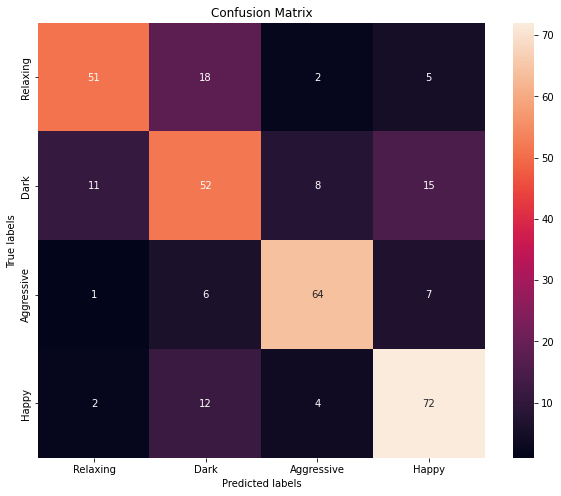

In [16]:
#Validando el modelo por medio de la matriz de confusión

conf_matrix = confusion_matrix(test_y, test_preds, labels = tracks['mood'].unique().tolist())
labels = tracks['mood'].unique().tolist()

plt.rcParams['figure.figsize'] = (10,8)
ax = plt.subplot()
sn.heatmap(conf_matrix, annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

## Guardando el modelo

In [26]:
import joblib

joblib.dump(model, 'music_mood_model.pkl')

['music_mood_model.pkl']

In [30]:
features = list(train_x.columns)
joblib.dump(features, 'features.pkl')

['features.pkl']

## Conclusiones

El modelo entrenado refleja una exactitud de un 72% con respecto a los datos de prueba y 73% con los datos de entrenamiento. Se efectuaron varios entrenamientos para intentar mejorar la exactitud del modelo, sin embargo no se evidenció ninguna mejora significativa al añadir más *playlists* al modelo de entrenamiento ni efectuando distintos experimentos con distintos parámetros tales como el número de capas ocultas o el valor de **alpha**. Debido a esto se puede concluir que el modelo generado anteriormente es el mejor. 